2024-04-16 06:00:29.473454: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


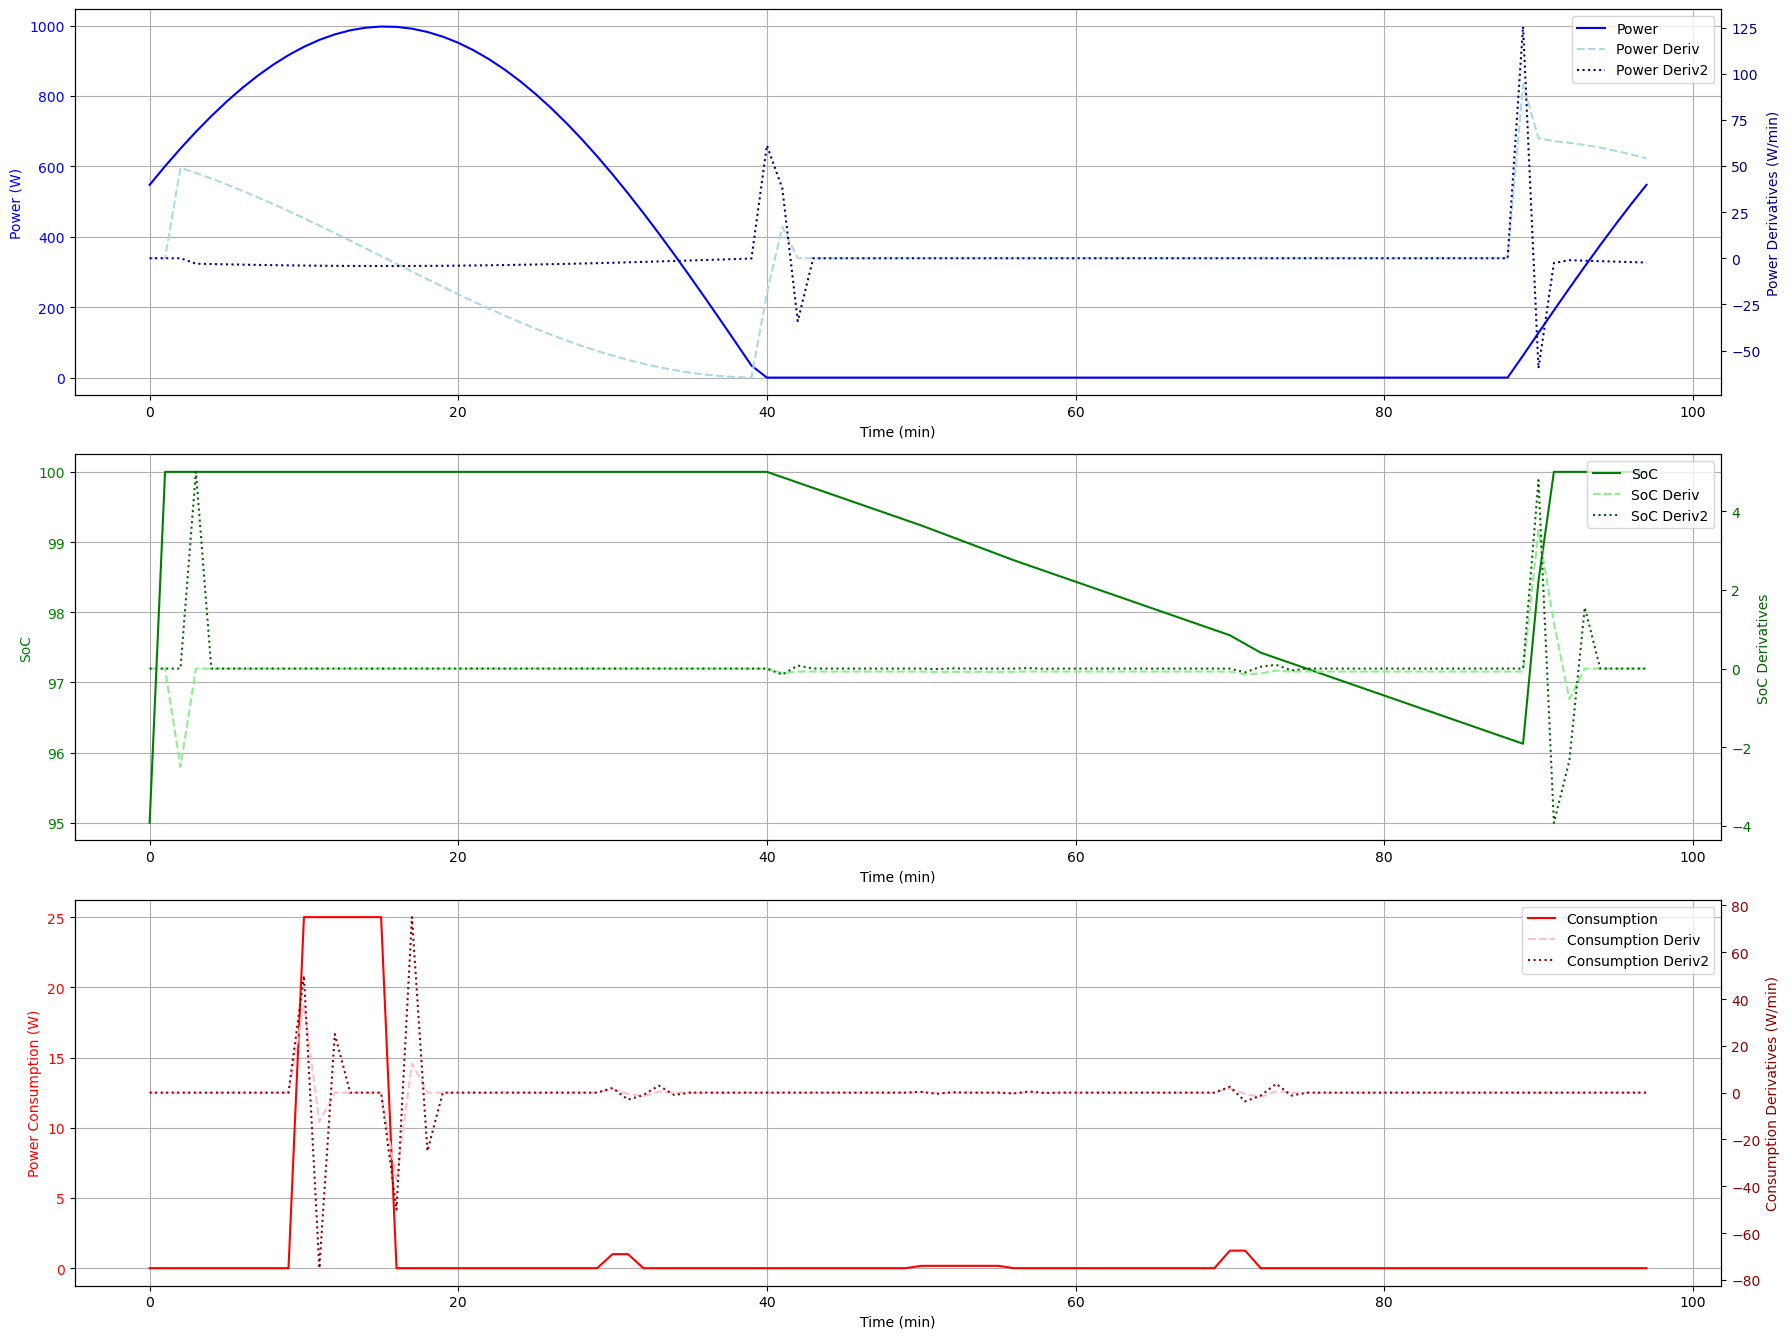

Time in each SoC range: {'0%-10%': 0, '10%-20%': 0, '20%-30%': 0, '30%-40%': 0, '40%-50%': 0, '50%-60%': 0, '60%-70%': 0, '70%-80%': 0, '80%-90%': 0, '90%-100%': 98.0}
Performance score: 100.0


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, chisquare
from math import pi, cos
from keras.models import Sequential
from keras.layers import Dense, Input
import tensorflow as tf

phase = np.random.rand() * 2 * pi
PtBatMax, PtMaxPanel = 43.68, 24.24
K, Eff = 191.1, 21.528 / 100
TInitial, TFinal, Dt = 0.0, 97.0, 1.0
SocInitial, HardDeck, SoftDeck = 95, 20, 30
NomConsum = 2
VOLTAGE = 12.0

TasksDf = pd.DataFrame({
    'TaskID': [1, 2, 3, 4],
    'Power': [150, 2.0, 1.0, 2.5],
    'StartTime': [10, 30, 50, 70],
    'Duration': [5, 1, 5, 1],
    'PriorityT': [0.2, 1, 0.4, 0.3],
    'PriorityE': [0.2, 1, 0.1, 0.9]
})

def available_power(t, phase, k, efficiency, pt_max_panel):
    return max(pt_max_panel * cos(2 * pi * t / TFinal + phase) * efficiency * k, 0)

def execute_tasks(times, tasks_df):
    consumption = np.zeros(len(times))
    for _, task in tasks_df.iterrows():
        start_index = np.argmax(times >= task['StartTime'])
        end_index = np.argmax(times >= task['StartTime'] + task['Duration'])
        if start_index and end_index:
            consumption[start_index:end_index + 1] += task['Power'] / (end_index - start_index + 1)
    return consumption

def manage_soc(times, power, consumption, soc_initial, pt_bat_max, dt, nom_consum):
    soc = np.zeros(len(times))
    soc[0] = soc_initial
    for i in range(1, len(times)):
        energy_generated = power[i - 1] * dt / 60
        energy_consumed = (nom_consum + consumption[i - 1]) * dt / 60
        soc[i] = soc[i - 1] + (energy_generated - energy_consumed) * 100 / pt_bat_max
        soc[i] = max(0, min(100, soc[i]))
    return soc

def calculate_derivatives(data, dt):
    d1 = np.zeros(len(data))
    d2 = np.zeros(len(data))
    for i in range(2, len(data)):
        d1[i] = (3 * data[i] - 4 * data[i - 1] + data[i - 2]) / (2 * dt)
        if i > 2:
            d2[i] = (2 * data[i] - 5 * data[i - 1] + 4 * data[i - 2] - data[i - 3]) / dt**2
    return d1, d2

def sample_parameters(n):
    sampled_params = []
    for _ in range(n):
        k_sampled = norm.rvs(191.1, 5)
        eff_sampled = norm.rvs(0.21528, 0.01)
        sampled_params.append((k_sampled, eff_sampled))
    return sampled_params

def analyze_time_in_soc_ranges(socs, dt):
    ranges = np.arange(0, 110, 10)
    time_in_ranges = {}
    for i in range(len(ranges) - 1):
        range_key = f"{ranges[i]}%-{ranges[i+1]}%"
        time_in_ranges[range_key] = 0

    for soc in socs:
        for i in range(len(ranges) - 1):
            if ranges[i] <= soc < ranges[i+1]:
                range_key = f"{ranges[i]}%-{ranges[i+1]}%"
                time_in_ranges[range_key] += dt
                break

        if soc == 100:
            range_key = f"{ranges[-2]}%-{ranges[-1]}%"
            time_in_ranges[range_key] += dt

    return time_in_ranges

def evaluate_performance(time_in_ranges):
    performance_score = 0
    for range_key, time in time_in_ranges.items():
        if "20%-30%" in range_key:
            performance_score += time * 2
        elif "0%-20%" in range_key:
            performance_score += time * 5
        else:
            performance_score += time
    return performance_score

times = np.arange(TInitial, TFinal + Dt, Dt)
powers = [available_power(t, phase, K, Eff, PtMaxPanel) for t in times]
consumption = execute_tasks(times, TasksDf)
socs = manage_soc(times, powers, consumption, SocInitial, PtBatMax, Dt, NomConsum)

power_derivs, power_derivs2 = calculate_derivatives(powers, Dt)
soc_derivs, soc_derivs2 = calculate_derivatives(socs, Dt)
consumption_derivs, consumption_derivs2 = calculate_derivatives(consumption, Dt)

plt.figure(figsize=(18, 13.5))

ax1 = plt.subplot(3, 1, 1)
p1, = ax1.plot(times, powers, label='Power', color='blue')
ax1.set_xlabel('Time (min)')
ax1.set_ylabel('Power (W)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

ax1b = ax1.twinx()
p2, = ax1b.plot(times, power_derivs, label='Power Deriv', linestyle='--', color='lightblue')
p3, = ax1b.plot(times, power_derivs2, label='Power Deriv2', linestyle=':', color='navy')
ax1b.set_ylabel('Power Derivatives (W/min)', color='navy')
ax1b.tick_params(axis='y', labelcolor='navy')
ax1.legend(handles=[p1, p2, p3], loc='upper right')

ax2 = plt.subplot(3, 1, 2)
s1, = ax2.plot(times, socs, label='SoC', color='green')
ax2.set_xlabel('Time (min)')
ax2.set_ylabel('SoC', color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.grid(True)

ax2b = ax2.twinx()
s2, = ax2b.plot(times, soc_derivs, label='SoC Deriv', linestyle='--', color='lightgreen')
s3, = ax2b.plot(times, soc_derivs2, label='SoC Deriv2', linestyle=':', color='darkgreen')
ax2b.set_ylabel('SoC Derivatives', color='darkgreen')
ax2b.tick_params(axis='y', labelcolor='darkgreen')
ax2.legend(handles=[s1, s2, s3], loc='upper right')

ax3 = plt.subplot(3, 1, 3)
c1, = ax3.plot(times, consumption, label='Consumption', color='red')
ax3.set_xlabel('Time (min)')
ax3.set_ylabel('Power Consumption (W)', color='red')
ax3.tick_params(axis='y', labelcolor='red')
ax3.grid(True)

ax3b = ax3.twinx()
c2, = ax3b.plot(times, consumption_derivs, label='Consumption Deriv', linestyle='--', color='pink')
c3, = ax3b.plot(times, consumption_derivs2, label='Consumption Deriv2', linestyle=':', color='darkred')
ax3b.set_ylabel('Consumption Derivatives (W/min)', color='darkred')
ax3b.tick_params(axis='y', labelcolor='darkred')
ax3.legend(handles=[c1, c2, c3], loc='upper right')

plt.tight_layout()
plt.savefig('final_dynamic_plot.png')
plt.show()

time_in_ranges = analyze_time_in_soc_ranges(socs, Dt)
performance_score = 100 * evaluate_performance(time_in_ranges)/(TFinal + 1)
print("Time in each SoC range:", time_in_ranges)
print("Performance score:", performance_score)
#tasks_vector = np.hstack((TasksDf['Power'].values, TasksDf['StartTime'].values, TasksDf['Duration'].values, TasksDf['PriorityT'].values, TasksDf['PriorityE'].values))
#neural_network_inputs = np.hstack((powers, power_derivs, power_derivs2, socs, soc_derivs, soc_derivs2), dtype=object)